In [1]:
! pip install tqdm
! pip install gym

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym 
from tqdm import tqdm 
 

### Базовый агент

In [3]:
class BasicAgent: 
    ''' 
    Базовый агент, от которого наследуются стратегии обучения 
    ''' 
    # Наименование алгоритма 
    ALGO_NAME = '---' 
    def __init__(self, env, eps=0.1): 
        # Среда         
        self.env = env         
        # Размерности Q-матрицы         
        self.nA = env.action_space.n         
        self.nS = env.observation_space.n 
        # и сама матрица 
        self.Q = np.zeros((self.nS, self.nA))         
        # Значения коэффициентов 
        # Порог выбора случайного действия         
        self.eps = eps 
        # Награды по эпизодам        
        self.episodes_reward = []    
    
    def print_q(self):        
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)        
        print(self.Q) 
    
    def get_state(self, state): 
        ''' 
        Возвращает правильное начальное состояние 
        '''        
        # Если состояние вернулось с виде кортежа, то вернуть только номер состояния           
        return state[0] if type(state) is tuple else state  

    def greedy(self, state): 
        ''' 
        <<Жадное>> текущее действие 
        Возвращает действие, соответствующее максимальному Q-значению         для состояния state 
        '''         
        return np.argmax(self.Q[state]) 
 
    def make_action(self, state): 
        ''' 
        Выбор действия агентом 
        '''         
        if np.random.uniform(0,1) < self.eps: 
            # Если вероятность меньше eps то выбирается случайное действие             
            return self.env.action_space.sample()
        # иначе действие, соответствующее максимальному Q-значению
        return self.greedy(state) 
 
    def draw_episodes_reward(self): 
        # Построение графика наград по эпизодам         
        fig, ax = plt.subplots(figsize = (15,10))         
        y = self.episodes_reward         
        x = list(range(1, len(y)+1)) 
        plt.plot(x, y, '-', linewidth=1, color='green')         
        plt.title('Награды по эпизодам')         
        plt.xlabel('Номер эпизода')         
        plt.ylabel('Награда') 
        plt.show() 
        
def learn(): 
    ''' 
    Реализация алгоритма обучения 
    '''    
    pass 

### Sarsa

In [4]:
class SARSA_Agent(BasicAgent):     
    ''' 
    Реализация алгоритма SARSA 
    ''' 
    # Наименование алгоритма 
    ALGO_NAME = 'SARSA' 
 
    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000): 
        # Вызов конструктора верхнего уровня         
        super().__init__(env, eps) 
        # Learning rate         
        self.lr=lr 
        # Коэффициент дисконтирования         
        self.gamma = gamma         
        # Количество эпизодов         
        self.num_episodes=num_episodes         
        # Постепенное уменьшение eps         
        self.eps_decay = 0.00005         
        self.eps_threshold = 0.01 
 
    def learn(self): 
        ''' 
        Обучение на основе алгоритма SARSA 
        ''' 
        self.episodes_reward = []         
        # Цикл по эпизодам         
        for ep in tqdm(list(range(self.num_episodes))): 
            # Начальное состояние среды 
            state = self.get_state(self.env.reset())             
            # Флаг штатного завершения эпизода             
            done = False 
            # Флаг нештатного завершения эпизода             
            truncated = False 
            # Суммарная награда по эпизоду             
            tot_rew = 0 
 
            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия 
            if self.eps > self.eps_threshold:                
                self.eps -= self.eps_decay 
            # Выбор действия        
            action = self.make_action(state)  
            
            # Проигрывание одного эпизода до финального состояния            
            while not (done or truncated): 
                # Выполняем шаг в среде                 
                next_state, rew, done, truncated, _ = self.env.step(action)  
                # Выполняем следующее действие  
                next_action = self.make_action(next_state)  
                    
                # Правило обновления Q для SARSA                 
                self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]) 

                # Следующее состояние считаем текущим                 
                state = next_state                 
                action = next_action                 
                # Суммарная награда за эпизод                 
                tot_rew += rew                 
                if (done or truncated): 
                    self.episodes_reward.append(tot_rew) 
 

### Q-обучение 

In [5]:
class QLearning_Agent(BasicAgent): 
    ''' 
    Реализация алгоритма Q-Learning 
    ''' 
    # Наименование алгоритма 
    ALGO_NAME = 'Q-обучение' 
 
    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000): 
        # Вызов конструктора верхнего уровня         
        super().__init__(env, eps) 
        # Learning rate         
        self.lr = lr 
        # Коэффициент дисконтирования         
        self.gamma = gamma         
        # Количество эпизодов         
        self.num_episodes=num_episodes         
        # Постепенное уменьшение eps         
        self.eps_decay = 0.00005         
        self.eps_threshold = 0.01 
 
    def learn(self): 
        ''' 
        Обучение на основе алгоритма Q-Learning 
        '''    
        self.episodes_reward = [] 
        # Цикл по эпизодам         
        for ep in tqdm(list(range(self.num_episodes))): 
            # Начальное состояние среды 
            state = self.get_state(self.env.reset())           
            # Флаг штатного завершения эпизода             
            done = False 
            # Флаг нештатного завершения эпизода             
            truncated = False 
            # Суммарная награда по эпизоду             
            tot_rew = 0 
 
            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия             
            if self.eps > self.eps_threshold:                 
                self.eps -= self.eps_decay 
 
            # Проигрывание одного эпизода до финального состояния             
            while not (done or truncated): 
 
                # Выбор действия 
                # В SARSA следующее действие выбиралось после шага в среде                  
                action = self.make_action(state)  
                 
                # Выполняем шаг в среде                 
                next_state, rew, done, truncated, _ = self.env.step(action)  
                # Правило обновления Q для SARSA (для сравнения) 
                # self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]) 
 
                # Правило обновления для Q-обучения 
                self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action]) 
 
                # Следующее состояние считаем текущим                 
                state = next_state 
                # Суммарная награда за эпизод                 
                tot_rew += rew                 
                if (done or truncated): 
                    self.episodes_reward.append(tot_rew) 

### Двойное Q-обучение 

  0%|          | 0/20000 [00:00<?, ?it/s]/home/dan/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 20000/20000 [00:12<00:00, 1617.26it/s]


Вывод Q-матриц для алгоритма  Двойное Q-обучение
Q1
[[ -19.73869119  -18.61385314  -12.39199909  -20.93534741]
 [ -17.94530037  -18.60350467  -11.55135223  -18.81140935]
 [ -18.29810207  -17.62331438  -10.95744187  -18.48171513]
 [ -17.35589852  -17.23877406  -10.0651672   -18.35262605]
 [ -13.94434103  -14.71214873   -9.16136601  -15.93063726]
 [ -13.56063406  -11.84493712   -8.31282151  -12.97337348]
 [ -10.92218511  -11.43127499   -9.04367578  -14.28497218]
 [ -10.21980375   -6.59566569   -6.39086157  -11.81171673]
 [  -6.71861631   -6.83618672   -5.70812169  -10.80037496]
 [  -6.60672046   -4.80343921   -4.65089947   -6.57947638]
 [  -4.38812406   -3.88160443   -4.54781843   -6.1520053 ]
 [  -3.49589409   -3.75752354   -2.94039998   -4.45617218]
 [ -13.65281265  -11.54888054  -11.66734626  -12.36862301]
 [ -12.33745571  -10.76640906  -10.76416381  -12.32128481]
 [ -12.06725708  -10.05359377   -9.96343246  -11.62719781]
 [ -11.65474534   -9.14635966   -9.39523281  -10.88934579]
 [ -

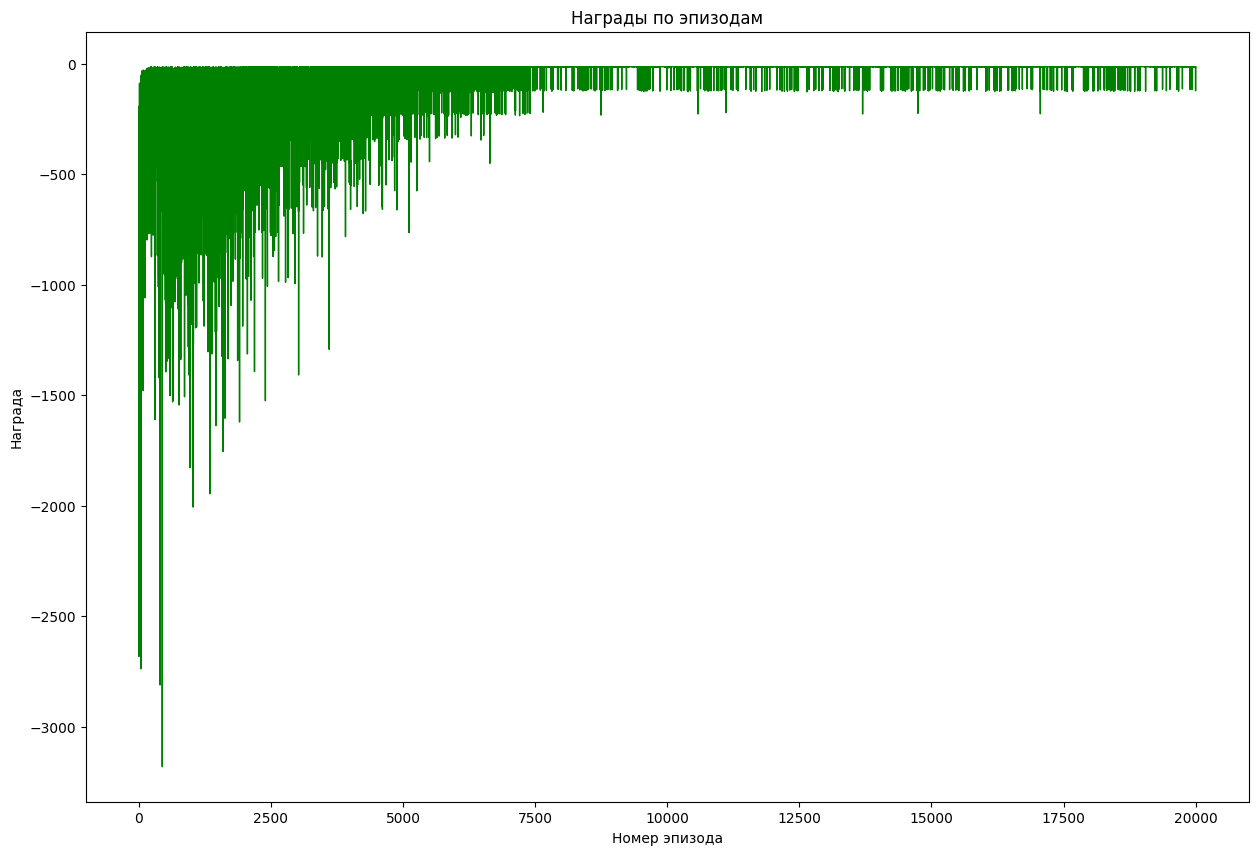

: 

In [6]:
class DoubleQLearning_Agent(BasicAgent): 
    ''' 
    Реализация алгоритма Double Q-Learning 
    ''' 
    # Наименование алгоритма 
    ALGO_NAME = 'Двойное Q-обучение' 
 
    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000): 
        # Вызов конструктора верхнего уровня         
        super().__init__(env, eps)         
        # Вторая матрица         
        self.Q2 = np.zeros((self.nS, self.nA)) 
        # Learning rate         
        self.lr=lr 
        # Коэффициент дисконтирования         
        self.gamma = gamma         
        # Количество эпизодов         
        self.num_episodes = num_episodes         
        # Постепенное уменьшение eps         
        self.eps_decay = 0.00005         
        self.eps_threshold = 0.01 
 
    def greedy(self, state): 
        ''' 
        <<Жадное>> текущее действие 
        Возвращает действие, соответствующее максимальному Q-значению         
        для состояния state 
        '''         
        temp_q = self.Q[state] + self.Q2[state]         
        return np.argmax(temp_q) 
 
    def print_q(self):         
        print('Вывод Q-матриц для алгоритма ', self.ALGO_NAME)         
        print('Q1')         
        print(self.Q)         
        print('Q2')         
        print(self.Q2) 
 
    def learn(self): 
        ''' 
        Обучение на основе алгоритма Double Q-Learning 
        '''         
        self.episodes_reward = []         
        # Цикл по эпизодам         
        for ep in tqdm(list(range(self.num_episodes))): 
            # Начальное состояние среды             
            state = self.get_state(self.env.reset())        
            # Флаг штатного завершения эпизода             
            done = False 
            # Флаг нештатного завершения эпизода          
            truncated = False 
            # Суммарная награда по эпизоду             
            tot_rew = 0 
 
            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия             
            if self.eps > self.eps_threshold:                 
                self.eps -= self.eps_decay 
 
            # Проигрывание одного эпизода до финального состояния             
            while not (done or truncated): 
                # Выбор действия 
                # В SARSA следующее действие выбиралось после шага в среде                  
                action = self.make_action(state)  
                 
                # Выполняем шаг в среде                 
                next_state, rew, done, truncated, _ = self.env.step(action) 
                if np.random.rand() < 0.5:                     
                    # Обновление первой таблицы                     
                    self.Q[state][action] = self.Q[state][action] + self.lr * (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])  
                else: 
                    # Обновление второй таблицы                     
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])  
                # Следующее состояние считаем текущим                 
                state = next_state 
                # Суммарная награда за эпизод                 
                tot_rew += rew                 
                if (done or truncated): 
                    self.episodes_reward.append(tot_rew) 
 

In [ ]:
def play_agent(agent): 
    ''' 
    Проигрывание сессии для обученного агента 
    ''' 
    env2 = gym.make('CliffWalking-v0', render_mode='human')      
    state = env2.reset()[0]     
    done = False     
    while not done: 
        action = agent.greedy(state)         
        next_state, reward, terminated, truncated, _ = env2.step(action)        
        env2.render()         
        state = next_state         
        if terminated or truncated: 
            done = True 
 
 
def run_sarsa(): 
    env = gym.make('CliffWalking-v0')      
    agent = SARSA_Agent(env)     
    agent.learn()     
    agent.print_q()     
    agent.draw_episodes_reward()     
    play_agent(agent) 
 
def run_q_learning(): 
    env = gym.make('CliffWalking-v0')      
    agent = QLearning_Agent(env)     
    agent.learn()     
    agent.print_q()     
    agent.draw_episodes_reward()     
    play_agent(agent) 
 
def run_double_q_learning(): 
    env = gym.make('CliffWalking-v0')      
    agent = DoubleQLearning_Agent(env)     
    agent.learn()     
    agent.print_q()     
    agent.draw_episodes_reward()     
    play_agent(agent) 
 
def main(): 
    #run_sarsa()     
    #run_q_learning()     
    run_double_q_learning() 
 
if __name__ == '__main__':     
    main() 